# Model fit

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import csv
import os 
from scipy.stats import spearmanr
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from model import micro, macro, params
from model import distributions as dist

## Model parameters

In [7]:
countries = ['us','de','dk','fr','it','nl','se','sp']
df = pd.read_pickle('../estimation/output/params_ref_us.pkl')
pars = df.loc[:,'value'].to_frame()
pars.columns = ['us']
for c in countries: 
	df = pd.read_pickle('../estimation/output/params_ref_'+c+'.pkl')
	pars[c] = df.loc[:,'value']
pars

,us,de,dk,fr,it,nl,se,sp
name,,,,,,,,
sigma,2.087206,2.087206,2.087206,2.087206,2.087206,2.087206,2.087206,2.087206
beta,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000
phi,0.270307,0.270307,0.270307,0.270307,0.270307,0.270307,0.270307,0.270307
psi,0.134476,0.134476,0.134476,0.134476,0.134476,0.134476,0.134476,0.134476
delta_h1,-1.016620,-1.316489,-1.653399,-1.089818,-0.836776,-1.565165,-1.299256,0.168136
delta_h2,3.418378,4.143322,4.298902,4.044104,3.918704,4.007505,4.321497,3.423365
eta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tfp,1.000000,1.030982,1.272984,0.954091,0.693128,1.041656,0.816839,0.842052
price,1.000000,0.821155,0.879503,0.711157,0.619461,0.615586,0.892487,0.642992


# Moments from Data

In [8]:
moms_h = pd.read_pickle('moments/means_health.pkl')
moms_m = pd.read_pickle('moments/means_macro.pkl').transpose()
moms = moms_m.merge(moms_h,left_index=True,right_index=True,how='left')
moms = moms.rename({'gg':'trans_fromgood','gb':'trans_frombad','g_q2':'grad2','g_q3':'grad3','g_q4':'grad4'},axis=0)
moms

,cshare,mshare,tfp,kshare,gg,gb,g_q2,g_q3,g_q4
co,,,,,,,,,
DK,NaN,0.090629,0.898205,4.134086,0.979945,0.349289,1.082923,1.083623,1.102843
FR,NaN,0.103574,0.735264,4.426736,0.974267,0.315457,1.031429,1.056177,1.090645
DE,NaN,0.102286,0.830156,3.807190,0.974090,0.327992,1.029659,1.071441,1.086319
IT,NaN,0.081089,0.739971,5.116111,0.971952,0.321932,1.022728,1.010093,1.039689
NL,NaN,0.088282,0.872562,4.294942,0.973459,0.476829,1.031051,1.025663,1.025642
SP,NaN,0.078123,0.640259,4.827075,0.965110,0.356402,1.027981,1.000185,1.054194
SE,NaN,0.085785,0.797962,4.131106,0.972339,0.302608,1.052746,1.063812,1.076431
US,0.687819,0.144225,1.000000,3.077725,0.961600,0.205977,1.177713,1.222356,1.276081


In [9]:
for c in countries:
	pi= np.zeros((2,2))
	pi[0,0] = moms.loc[c.upper(),'gg']
	pi[0,1] = 1.0 - pi[0,0]
	pi[1,0] = moms.loc[c.upper(),'gb']
	pi[1,1] = 1.0 - pi[1,0]	
	pi   = np.linalg.matrix_power(pi, 1000)
	moms.loc[c.upper(),'h'] = pi[0,0]
moms

,cshare,mshare,tfp,kshare,gg,gb,g_q2,g_q3,g_q4,h
co,,,,,,,,,,
DK,NaN,0.090629,0.898205,4.134086,0.979945,0.349289,1.082923,1.083623,1.102843,0.945700
FR,NaN,0.103574,0.735264,4.426736,0.974267,0.315457,1.031429,1.056177,1.090645,0.924579
DE,NaN,0.102286,0.830156,3.807190,0.974090,0.327992,1.029659,1.071441,1.086319,0.926788
IT,NaN,0.081089,0.739971,5.116111,0.971952,0.321932,1.022728,1.010093,1.039689,0.919857
NL,NaN,0.088282,0.872562,4.294942,0.973459,0.476829,1.031051,1.025663,1.025642,0.947274
SP,NaN,0.078123,0.640259,4.827075,0.965110,0.356402,1.027981,1.000185,1.054194,0.910834
SE,NaN,0.085785,0.797962,4.131106,0.972339,0.302608,1.052746,1.063812,1.076431,0.916247
US,0.687819,0.144225,1.000000,3.077725,0.961600,0.205977,1.177713,1.222356,1.276081,0.842864


In [ ]:
moms.to_pickle('output/moms.pkl')

# General Equilibrium

In [10]:
def eq(co,pars):
    # estimated parameters 
    p = pars.loc[:,co]
    itax = True
    theta = params.flexpars(sigma=p['sigma'],beta=p['beta'],
                          phi=p['phi'],psi=p['psi'],delta_h1=p['delta_h1'],
                          delta_h2=p['delta_h2'],eta=0.0,tfp=p['tfp'],price=p['price'])
    # option for the numerical solution
    ne = 10
    m  = 2.5
    if co == 'us':
        op = params.settings(ne=ne,nk=30,maxk=190.0,curv=0.5,nprocs=48)
    else:
        op = params.settings(ne=ne,nk=30,maxk=150.0,curv=0.5,nprocs=48)
    inc = params.incprocess(country=co)
    inc.tauchen(ne=ne,m=m)
    aux = params.auxpars(country=co)  
    #Decision rules
    csumers = micro.bellman(options=op,flex=theta,aux=aux,inc=inc,rent=5.6e-2)
    csumers.compute_cash()
    csumers.itervalue()
    # distribution
    stats = dist.stationary(dp=csumers,nk=100)
    stats.blowup()
    stats.compute()
    # general equilibrium
    eq = macro.equilibrium(stats=stats,taxes=itax,rent=True)
    eq.solve()
    aggs = eq.aggregates()
    hlth = eq.healthreport()
    s    = p['price']*aggs.M/aggs.Y
    coy  = (aggs.C + p['price']*aggs.M)/aggs.Y
    h    = hlth.pH
    tbad = hlth.pTransBad
    tgood = hlth.pTransGood
    g    = hlth.gradient
    outcomes = [coy,s,tbad,tgood,h,g[0],g[1],g[2],aggs.Y]
    names = ['cshare','mshare','gb','gg','h','g_q2','g_q3','g_q4','tfp']
    return pd.Series(index=names,data=outcomes)

## Simulated Moments

In [11]:
countries = ['us','de','dk','fr','it','nl','se','sp']
moms_sim = pd.DataFrame(index=['cshare','mshare','gb','gg','h','g_q2','g_q3','g_q4','tfp'],columns=countries)
for c in countries:
   print('doing country ',c)
   ms = eq(c,pars)
   moms_sim.loc[:,c] = ms 

In [ ]:
moms_sim.loc['tfp',:] = moms_sim.loc['tfp',:]/moms_sim.loc['tfp','us']
moms_sim = moms_sim.transpose()
moms_sim.to_pickle('output/moms_sim.pkl')
moms_sim

## Figures of the fit


In [ ]:
moms_sim = pd.read_pickle('output/moms_sim.pkl')
moms = pd.read_pickle('output/moms.pkl')

In [ ]:
def fit_moment(name,moms,moms_sim,show=False):
	plt.figure()
	plt.scatter(moms[name],moms_sim[name],facecolors='none',edgecolors='b',s=500.0)
	plt.plot(moms[name],moms[name])
	plt.xlabel('data')
	plt.ylabel('simulated data')
	for c in countries:
    		plt.annotate(c,xy=(moms.loc[c.upper(),name], moms_sim.loc[c.upper(),name]),
		    horizontalalignment='center', verticalalignment='center')
	plt.savefig('../figures/fig_d1_'+name+'.eps',dpi=1200)
	print('figure ','../figures/fig_d1_'+name+'.eps',' saved...')
	if show:
		plt.show()
	return 

In [ ]:
for m in ['mshare','tfp','gg','gb','g_q2','g_q3','g_q4','h']:
	fit_moment(m,moms,moms_sim)
	res_spear_rho, res_spear_pv = spearmanr(moms_sim[m], moms[m])
	print('moment :', m, ' ,spearman = ',[res_spear_rho, res_spear_pv])

# Additional information 

## EU - US Differences

In [13]:
# pop size 2005
pop_co = ['dk','fr','de','it','nl','sp','se','us']
pops = [5149,61181,82469,58607,16319,43662,9029,295516]
pop = dict(zip(pop_co,pops))
countries_eu = [c for c in countries if c!='us']
for c in countries:
	pars.loc['pop',c] = pop[c]
price_eu = pars.loc['price',countries_eu].mean(axis=1)
tfp_eu = pars.loc['tfp',countries_eu].mean(axis=1)
print('- unweighted (price,tfp) = ', (price_eu,tfp_eu))
wprice_eu = (pars.loc['price',countries_eu]*pars.loc['pop',countries_eu]).sum()/pars.loc['pop',countries_eu]).sum()
wtfp_eu = (pars.loc['tfp',countries_eu]*pars.loc['pop',countries_eu]).sum()/pars.loc['pop',countries_eu]).sum()
print('- weighted (price,tfp) = ', (wprice_eu,wtfp_eu))

0.7450567946438661 0.7137430518130534


## TFP comparisons (Groningen vs. Banque France)

### TFP gaps

In [15]:
""" from pandas import read_excel
file_name = 'xlsx_files/TFP_data.xlsx' # name of your excel file
my_sheet  = 'data2'    # sheet name
data_tfp_ts   = read_excel(file_name, sheet_name = my_sheet) """

/Users/flangot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  after removing the cwd from sys.path.


In [16]:
""" print("Groningen")
res_spear_rho, res_spear_pv = spearmanr(pars.loc['tfp',:], data_tfp_ts.loc[:,'Groningen 1997'])
print([res_spear_rho, res_spear_pv])
print("Banque de France")
res_spear_rho, res_spear_pv = spearmanr(pars.loc['tfp',:], data_tfp_ts.loc[:,'Banque de France'])
print([res_spear_rho, res_spear_pv]) """

Groningen
[0.9047619047619048, 0.0020082755054294677]
Banque de France
[0.7619047619047621, 0.028004939153071794]


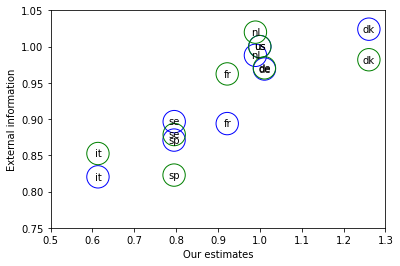

In [17]:
""" plt.figure()
plt.scatter(pars.loc['tfp',:],data_tfp_ts.loc[:,'Groningen 1997'],facecolors='none', edgecolors='b',s=500.0)
plt.scatter(pars.loc['tfp',:],data_tfp_ts.loc[:,'Banque de France'],facecolors='none', edgecolors='g',s=500.0)
plt.xlim(0.5,1.3)
plt.ylim(0.75,1.05)
plt.xlabel('Our estimates')
plt.ylabel('External information')
for x,y,z in zip(pars.loc['tfp',:],data_tfp_ts.loc[:,'Groningen 1997'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
for x,y,z in zip(pars.loc['tfp',:],data_tfp_ts.loc[:,'Banque de France'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
#plt.savefig('../figures_JPE/tfp_vs_data.eps',dpi=600) """